In [1]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Statistics

include("../helpers.jl");
include("../stats.jl");

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [4]:
# decorrelate x_df
function dynamicscale(data_raw, dynamic_lower, upper)
    return (data_raw .- dynamic_lower) ./ (upper .- dynamic_lower)
end

max_dvar_3 = 160
eta_3 = 10.
max_dvar_5 = 1.85
eta_5 = 0.05
max_dvar_12 = 2.0
eta_12 = 0.05
max_dvar_9 = -25.
eta_9 = 2.5
max_dvar_13 = -20.
eta_13 = 2.5

dvar_3_prime = dynamicscale(x_df[:, "DVAR3"], eta_3 .+ x_df[:, "DVAR2"], max_dvar_3)
dvar_5_prime = dynamicscale(x_df[:, "DVAR5"], x_df[:, "DVAR4"] .+ eta_5, max_dvar_5)
dvar_12_prime = dynamicscale(x_df[:, "DVAR12"], x_df[:, "DVAR5"] .+ eta_12, max_dvar_12)
dvar_9_prime = dynamicscale(x_df[:, "DVAR9"], x_df[:, "DVAR8"] .+ eta_9, max_dvar_9)
dvar_13_prime = dynamicscale(x_df[:, "DVAR13"], x_df[:, "DVAR9"] .+ eta_13, max_dvar_13)

x_df[:, "DVAR3"] = dvar_3_prime;
x_df[:, "DVAR5"] = dvar_5_prime;
x_df[:, "DVAR12"] = dvar_12_prime;
x_df[:, "DVAR9"] = dvar_9_prime;
x_df[:, "DVAR13"] = dvar_13_prime;

In [5]:
# scaling data
x_scaled_df = minmaxscaledf(x_df)[1]
y_scaled_df = minmaxscaledf(y_df)[1]

@assert(all(maximum(y_scaled_df[!, colname]) == 1. for colname in names(y_scaled_df)))
@assert(all(minimum(y_scaled_df[!, colname]) == -1. for colname in names(y_scaled_df)))

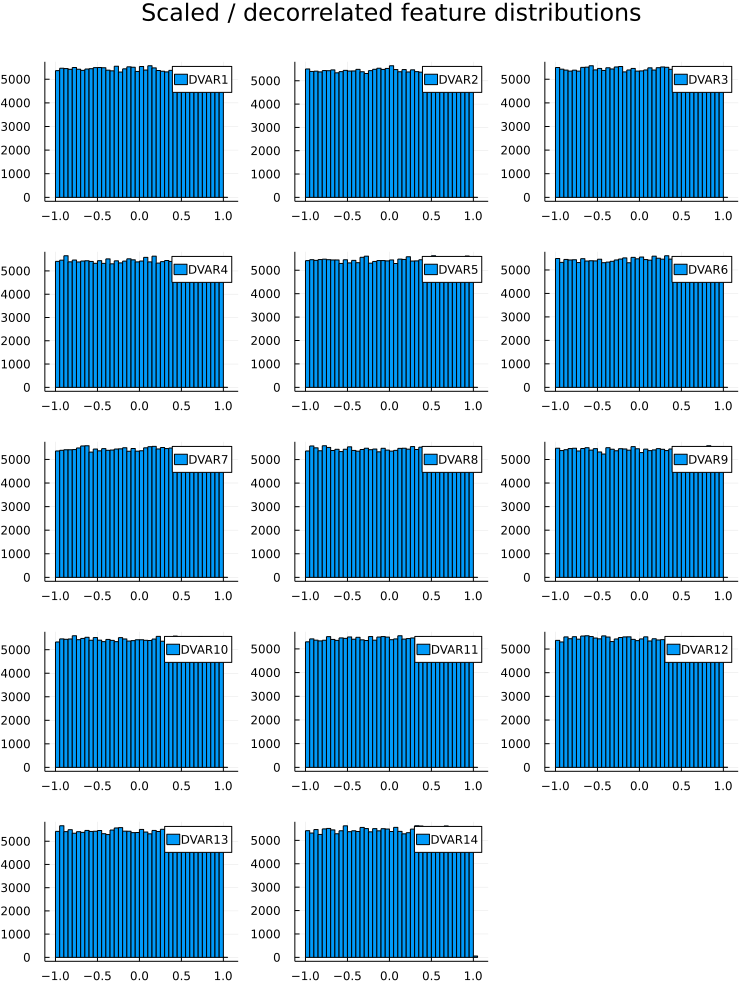

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_scaled_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Scaled / decorrelated feature distributions")

In [7]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [8]:
# format to arrays
x_train = Float64.(Matrix(x_train_df)); x_test = Float64.(Matrix(x_test_df));
y_train = Float64.(Matrix(y_train_df)); y_test = Float64.(Matrix(y_test_df));

In [9]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Neural nets with and without dropout layers

Here I choose a depth 6, width 200 neural network with a batch size of 1024, as previous analyses hinted at the fact that a neural network like this might be overfitting.

In one neural network, between each 200-width layer I add a dropout layer with dropout rate $0.75$.

In [43]:
# nets
function neuralnetwork()
    Chain(
        Dense(x_dimension, 200, x->σ.(x)),
        Dense(200, 200, x->σ.(x)),
        Dense(200, 200, x->σ.(x)),
        Dense(200, 200, x->σ.(x)),
        Dense(200, 200, x->σ.(x)),
        Dense(200, 200, x->σ.(x)),
        Dense(200, y_dimension)
    )
end

dropout_rate = 0.5

function neuralnetworkwithdropout()
    Chain(
        Dense(x_dimension, 200, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(200, 200, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(200, 200, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(200, 200, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(200, 200, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(200, 200, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(200, y_dimension)
    )
end

neuralnetworkwithdropout (generic function with 1 method)

In [11]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [12]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 2500
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=14.61414572204361
epoch 2, loss=5.410723599271271
epoch 3, loss=2.9992180267295026
epoch 4, loss=2.1146519920129974
epoch 5, loss=1.8220641170270324
epoch 6, loss=1.7463568572918888
epoch 7, loss=1.6779921579338697
epoch 8, loss=1.6927446252186855
epoch 9, loss=1.6183590706823245
epoch 10, loss=1.5635689435229567
epoch 11, loss=1.519932007711317
epoch 12, loss=1.4926176901323036
epoch 13, loss=1.4825945597931263
epoch 14, loss=1.440012879536481
epoch 15, loss=1.3933963630222457
epoch 16, loss=1.3832835744821699
epoch 17, loss=1.3501624650669906
epoch 18, loss=1.293171210263007
epoch 19, loss=1.2930479267465964
epoch 20, loss=1.2044347136354085
epoch 21, loss=1.1860344495762365
epoch 22, loss=1.15648423648796
epoch 23, loss=1.1633031630337467
epoch 24, loss=1.1456428879247509
epoch 25, loss=1.2034792928114217
epoch 26, loss=1.0999175707678748
epoch 27, loss=1.249211504519026
epoch 28, loss=1.136645548305279
epoch 29, loss=1.093389078579074
epoch 30, loss=1.0994469569183887

epoch 239, loss=0.847016889059161
epoch 240, loss=0.8548388100385113
epoch 241, loss=0.8413237985736742
epoch 242, loss=0.849143739860728
epoch 243, loss=0.8499248060602422
epoch 244, loss=0.8362634798412202
epoch 245, loss=0.8411614229680655
epoch 246, loss=0.8379366723262104
epoch 247, loss=0.8362875290954963
epoch 248, loss=0.8436166334940124
epoch 249, loss=0.832850246722132
epoch 250, loss=0.8396212177494391
epoch 251, loss=0.8404522720296205
epoch 252, loss=0.8377654010951364
epoch 253, loss=0.8398766247417864
epoch 254, loss=0.8381053625582706
epoch 255, loss=0.8402521056603428
epoch 256, loss=0.8455781650349058
epoch 257, loss=0.8337673454393023
epoch 258, loss=0.838303879664188
epoch 259, loss=0.8443328473920201
epoch 260, loss=0.8328475416674823
epoch 261, loss=0.847930947465808
epoch 262, loss=0.8384924243076463
epoch 263, loss=0.8397538605010799
epoch 264, loss=0.8348696615556184
epoch 265, loss=0.8304513053833367
epoch 266, loss=0.8380744459627244
epoch 267, loss=0.8401894

epoch 473, loss=0.7784513986282687
epoch 474, loss=0.7795611663464757
epoch 475, loss=0.780626284932005
epoch 476, loss=0.7840716309326841
epoch 477, loss=0.7847404743914785
epoch 478, loss=0.7767540650312225
epoch 479, loss=0.7749020165603513
epoch 480, loss=0.7754959782400749
epoch 481, loss=0.7806424981406473
epoch 482, loss=0.7822588805469699
epoch 483, loss=0.7806051193150569
epoch 484, loss=0.7769620365798567
epoch 485, loss=0.782918706726508
epoch 486, loss=0.7786555428643523
epoch 487, loss=0.7741745954596935
epoch 488, loss=0.7740436967108698
epoch 489, loss=0.7767872265729554
epoch 490, loss=0.782240843374729
epoch 491, loss=0.7764789777405504
epoch 492, loss=0.7735047737796096
epoch 493, loss=0.7705121906848786
epoch 494, loss=0.7716024821327029
epoch 495, loss=0.7737760916972105
epoch 496, loss=0.7812529009629621
epoch 497, loss=0.7800756362269267
epoch 498, loss=0.7734359426393689
epoch 499, loss=0.772079812905783
epoch 500, loss=0.7756890897044666
epoch 501, loss=0.779075

epoch 707, loss=0.7173701860768217
epoch 708, loss=0.7240642358366003
epoch 709, loss=0.7164370280576348
epoch 710, loss=0.7253212448583377
epoch 711, loss=0.7188222503990023
epoch 712, loss=0.7165007644964002
epoch 713, loss=0.7163723789932804
epoch 714, loss=0.7192478277498644
epoch 715, loss=0.7148045124057067
epoch 716, loss=0.713228440191922
epoch 717, loss=0.7166094508378921
epoch 718, loss=0.7134303675563751
epoch 719, loss=0.7216743740537043
epoch 720, loss=0.7115477689680001
epoch 721, loss=0.7171777317710853
epoch 722, loss=0.7172924748562837
epoch 723, loss=0.7143658619996806
epoch 724, loss=0.7177381266498717
epoch 725, loss=0.7147641809499873
epoch 726, loss=0.7246435480264249
epoch 727, loss=0.7140687642667706
epoch 728, loss=0.7174995655640182
epoch 729, loss=0.7089048522406122
epoch 730, loss=0.7105974163962515
epoch 731, loss=0.713113742981529
epoch 732, loss=0.713090886021183
epoch 733, loss=0.7097721282272852
epoch 734, loss=0.7124727262527991
epoch 735, loss=0.71112

epoch 942, loss=0.6307649680812051
epoch 943, loss=0.6299030078328433
epoch 944, loss=0.6330289588799894
epoch 945, loss=0.63032452279326
epoch 946, loss=0.6279691371715017
epoch 947, loss=0.6215930928563693
epoch 948, loss=0.6310890185573677
epoch 949, loss=0.6238957730735845
epoch 950, loss=0.6228164493131905
epoch 951, loss=0.6228303140132287
epoch 952, loss=0.6233822737001667
epoch 953, loss=0.6275602263964
epoch 954, loss=0.6178687978062449
epoch 955, loss=0.6241029822362871
epoch 956, loss=0.6217658817503275
epoch 957, loss=0.6235320906794363
epoch 958, loss=0.6327414395408331
epoch 959, loss=0.6187576354594041
epoch 960, loss=0.6279984379123061
epoch 961, loss=0.627784614401532
epoch 962, loss=0.6230913640500728
epoch 963, loss=0.6219289526115578
epoch 964, loss=0.6200732082782521
epoch 965, loss=0.6155201569611056
epoch 966, loss=0.6214334804809765
epoch 967, loss=0.6199784707288548
epoch 968, loss=0.6149112072810267
epoch 969, loss=0.6278521114250629
epoch 970, loss=0.61667324

epoch 1172, loss=0.5342777579809058
epoch 1173, loss=0.5328632278474803
epoch 1174, loss=0.5343768239497797
epoch 1175, loss=0.529585101001616
epoch 1176, loss=0.5289369192219754
epoch 1177, loss=0.5321979544346935
epoch 1178, loss=0.534780498620643
epoch 1179, loss=0.5365100530310152
epoch 1180, loss=0.5347885614780687
epoch 1181, loss=0.5309670995862853
epoch 1182, loss=0.5281412529700306
epoch 1183, loss=0.5314763555151741
epoch 1184, loss=0.5245544148389477
epoch 1185, loss=0.5316625896560285
epoch 1186, loss=0.5339068046854921
epoch 1187, loss=0.5261701909868752
epoch 1188, loss=0.5263168508268504
epoch 1189, loss=0.5259131310955137
epoch 1190, loss=0.5233682404913709
epoch 1191, loss=0.527101997164647
epoch 1192, loss=0.5284871681057813
epoch 1193, loss=0.5283525279377788
epoch 1194, loss=0.5261341172573353
epoch 1195, loss=0.5231643032178243
epoch 1196, loss=0.5216436707618484
epoch 1197, loss=0.5248048923807174
epoch 1198, loss=0.5263714365081817
epoch 1199, loss=0.523872770745

epoch 1399, loss=0.4492545107852167
epoch 1400, loss=0.4496065930334443
epoch 1401, loss=0.44651925769427747
epoch 1402, loss=0.4558246464166868
epoch 1403, loss=0.44902266171743055
epoch 1404, loss=0.4569406109125096
epoch 1405, loss=0.4578127898031662
epoch 1406, loss=0.4539988825520935
epoch 1407, loss=0.4525979163382579
epoch 1408, loss=0.4461369577852896
epoch 1409, loss=0.4507401826452712
epoch 1410, loss=0.44452193561386055
epoch 1411, loss=0.45060358866110145
epoch 1412, loss=0.4477540641994569
epoch 1413, loss=0.4494713933618987
epoch 1414, loss=0.44443414204817583
epoch 1415, loss=0.4518820467484246
epoch 1416, loss=0.4484364789003085
epoch 1417, loss=0.44302711634514985
epoch 1418, loss=0.4432913210839888
epoch 1419, loss=0.452406628889159
epoch 1420, loss=0.44810392852835046
epoch 1421, loss=0.44497481931873156
epoch 1422, loss=0.44387227367472454
epoch 1423, loss=0.440767617412615
epoch 1424, loss=0.44715892642123606
epoch 1425, loss=0.4444364779899195
epoch 1426, loss=0.4

epoch 1624, loss=0.3894573015570462
epoch 1625, loss=0.38884050646627244
epoch 1626, loss=0.38719777578328185
epoch 1627, loss=0.39021556196721924
epoch 1628, loss=0.3881637092588635
epoch 1629, loss=0.3918089867215789
epoch 1630, loss=0.3865838463500544
epoch 1631, loss=0.38551051492052835
epoch 1632, loss=0.3898164239657982
epoch 1633, loss=0.3884442321621113
epoch 1634, loss=0.3887322385102433
epoch 1635, loss=0.38745469899275564
epoch 1636, loss=0.3917352042982934
epoch 1637, loss=0.39657840810380807
epoch 1638, loss=0.38331841963235735
epoch 1639, loss=0.3844939675490885
epoch 1640, loss=0.38683411663303563
epoch 1641, loss=0.3863595407802512
epoch 1642, loss=0.3941028006483329
epoch 1643, loss=0.38354925911847526
epoch 1644, loss=0.38410112719168926
epoch 1645, loss=0.3859025642574061
epoch 1646, loss=0.38755804154445134
epoch 1647, loss=0.3900919627527584
epoch 1648, loss=0.38643691909589034
epoch 1649, loss=0.3865895962821106
epoch 1650, loss=0.3826438918872434
epoch 1651, loss

epoch 1849, loss=0.34037008709977207
epoch 1850, loss=0.34375920475492666
epoch 1851, loss=0.340740855245548
epoch 1852, loss=0.34555305355333876
epoch 1853, loss=0.34422615769245013
epoch 1854, loss=0.3428675568267273
epoch 1855, loss=0.3477809931918072
epoch 1856, loss=0.3430645143518117
epoch 1857, loss=0.3377963546437336
epoch 1858, loss=0.3417171312923828
epoch 1859, loss=0.343569650347334
epoch 1860, loss=0.34036426557521343
epoch 1861, loss=0.34273759766083534
epoch 1862, loss=0.33907478985438066
epoch 1863, loss=0.34100969231227024
epoch 1864, loss=0.33963257618603554
epoch 1865, loss=0.3427057409932776
epoch 1866, loss=0.33936043786030107
epoch 1867, loss=0.34032413345263496
epoch 1868, loss=0.3424097908371505
epoch 1869, loss=0.3420502551389448
epoch 1870, loss=0.3415584621889696
epoch 1871, loss=0.3357705455546022
epoch 1872, loss=0.3369393409050512
epoch 1873, loss=0.3388519827723275
epoch 1874, loss=0.34584236733166773
epoch 1875, loss=0.34189283065297393
epoch 1876, loss=

epoch 2075, loss=0.31140105035760607
epoch 2076, loss=0.30972432972899755
epoch 2077, loss=0.3075822067822464
epoch 2078, loss=0.31512533256717395
epoch 2079, loss=0.30781184623428326
epoch 2080, loss=0.31439742293878853
epoch 2081, loss=0.3087899456871819
epoch 2082, loss=0.30548827035909726
epoch 2083, loss=0.3068506527649392
epoch 2084, loss=0.3073642263979637
epoch 2085, loss=0.3085518883864883
epoch 2086, loss=0.3087601894674624
epoch 2087, loss=0.30483598284980856
epoch 2088, loss=0.3090837485341607
epoch 2089, loss=0.3079563141610141
epoch 2090, loss=0.30952084006113195
epoch 2091, loss=0.30439248815735065
epoch 2092, loss=0.30626155001983424
epoch 2093, loss=0.30455125709336267
epoch 2094, loss=0.30584023670667476
epoch 2095, loss=0.30984076617167017
epoch 2096, loss=0.30543354887545254
epoch 2097, loss=0.31104154128896566
epoch 2098, loss=0.3044918659817911
epoch 2099, loss=0.30528266848103724
epoch 2100, loss=0.30487191636673283
epoch 2101, loss=0.31062407534078984
epoch 2102

epoch 2299, loss=0.2801270126240025
epoch 2300, loss=0.2840781143833422
epoch 2301, loss=0.28772585698062303
epoch 2302, loss=0.28500645860811924
epoch 2303, loss=0.2885879810995708
epoch 2304, loss=0.28727504235547724
epoch 2305, loss=0.28035374017870224
epoch 2306, loss=0.2807258154309971
epoch 2307, loss=0.2788969386587927
epoch 2308, loss=0.28153375020554816
epoch 2309, loss=0.2828454731276052
epoch 2310, loss=0.28068004382797057
epoch 2311, loss=0.28828410514043773
epoch 2312, loss=0.2828397973277267
epoch 2313, loss=0.2836736370154345
epoch 2314, loss=0.28236450212022773
epoch 2315, loss=0.28152459667901014
epoch 2316, loss=0.2856127505292061
epoch 2317, loss=0.2795117622951337
epoch 2318, loss=0.28180809168815973
epoch 2319, loss=0.2826613350910601
epoch 2320, loss=0.2816194521449097
epoch 2321, loss=0.27964687943795025
epoch 2322, loss=0.28204943433824886
epoch 2323, loss=0.2833486079678226
epoch 2324, loss=0.28064057720901964
epoch 2325, loss=0.27848119644192637
epoch 2326, lo

In [13]:
# organizing data into batches for dropout network
data_loader_2 = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [44]:
# defining our model, optimization algorithm and loss function
m_dropout = neuralnetworkwithdropout()
loss_dropout(x, y) = Flux.mse(m_dropout(x), y)

# training
training_losses_dropout = Float32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss_dropout, Flux.params(m_dropout), data_loader_2, optimizer)
    l = 0.
    for d in data_loader_2
        l += loss_dropout(d...)
    end
    println(" loss=$l")
    push!(training_losses_dropout, l)
end

epoch 1, loss=15.58982234953387
epoch 2, loss=15.167867403219352
epoch 3, loss=15.05087465987923
epoch 4, loss=14.936017821302272
epoch 5, loss=14.876828677314597
epoch 6, loss=14.838001895495632
epoch 7, loss=14.820435898199795
epoch 8, loss=14.799884617988623
epoch 9, loss=14.795551829141159
epoch 10, loss=14.77895504221598
epoch 11, loss=14.769699060987383
epoch 12, loss=14.755209646172132
epoch 13, loss=9.97544310225864
epoch 14, loss=8.8376816092686
epoch 15, loss=8.365143242307326
epoch 16, loss=8.062322180260399
epoch 17, loss=7.621707328594055
epoch 18, loss=7.208586124070012
epoch 19, loss=6.3209711290387744
epoch 20, loss=4.496871496292313
epoch 21, loss=4.111825963685393
epoch 22, loss=3.8571154984914706
epoch 23, loss=3.702677922400925
epoch 24, loss=3.104984677704911
epoch 25, loss=2.7976723123381015
epoch 26, loss=2.65695612704021
epoch 27, loss=2.5035125476363906
epoch 28, loss=2.4614118589319993
epoch 29, loss=2.388008116054378
epoch 30, loss=2.302568195055608
epoch 31,

epoch 240, loss=1.2654798797673408
epoch 241, loss=1.2654857591548465
epoch 242, loss=1.273621422113605
epoch 243, loss=1.277484727172127
epoch 244, loss=1.2632836920583412
epoch 245, loss=1.2645503300331271
epoch 246, loss=1.261284349379097
epoch 247, loss=1.2758864440715896
epoch 248, loss=1.2723017876806468
epoch 249, loss=1.2641975108334071
epoch 250, loss=1.2470232964303418
epoch 251, loss=1.260162996274074
epoch 252, loss=1.2440917551773134
epoch 253, loss=1.2434022076695208
epoch 254, loss=1.2592400158799943
epoch 255, loss=1.2646554195126491
epoch 256, loss=1.2569246941287011
epoch 257, loss=1.2397372085281133
epoch 258, loss=1.2626523442587414
epoch 259, loss=1.247398749316483
epoch 260, loss=1.2373180480036687
epoch 261, loss=1.2611183045258845
epoch 262, loss=1.2565578645128732
epoch 263, loss=1.2705296107869164
epoch 264, loss=1.2538485216614723
epoch 265, loss=1.2522684799557433
epoch 266, loss=1.262582764751506
epoch 267, loss=1.236333706576754
epoch 268, loss=1.268387214

epoch 475, loss=1.1954392643617877
epoch 476, loss=1.189308012914198
epoch 477, loss=1.1963312389497076
epoch 478, loss=1.1925287566856069
epoch 479, loss=1.182420997237213
epoch 480, loss=1.1916475998266893
epoch 481, loss=1.1955843584522714
epoch 482, loss=1.2032278287881308
epoch 483, loss=1.1842239544263125
epoch 484, loss=1.1943150215351175
epoch 485, loss=1.2026917897632152
epoch 486, loss=1.2009090433575338
epoch 487, loss=1.1866331881830654
epoch 488, loss=1.1776602275478139
epoch 489, loss=1.1925146107129805
epoch 490, loss=1.196149610098458
epoch 491, loss=1.1914395845646215
epoch 492, loss=1.1808694792823138
epoch 493, loss=1.1827191420667862
epoch 494, loss=1.1764858078579532
epoch 495, loss=1.2000210475615636
epoch 496, loss=1.1887649934977198
epoch 497, loss=1.1948551389915836
epoch 498, loss=1.1930580081897098
epoch 499, loss=1.1824321498417818
epoch 500, loss=1.1816411394307373
epoch 501, loss=1.176728154307259
epoch 502, loss=1.1832684333018313
epoch 503, loss=1.187615

epoch 711, loss=1.1622891090960934
epoch 712, loss=1.1550300239592297
epoch 713, loss=1.1512526095485054
epoch 714, loss=1.1595958964539403
epoch 715, loss=1.170830094384493
epoch 716, loss=1.1661244347426516
epoch 717, loss=1.160570303230878
epoch 718, loss=1.1616295164094623
epoch 719, loss=1.1635285262468287
epoch 720, loss=1.1524966977155762
epoch 721, loss=1.1538699366953065
epoch 722, loss=1.1514098217333406
epoch 723, loss=1.1570360821088723
epoch 724, loss=1.1550224998836085
epoch 725, loss=1.160000213442743
epoch 726, loss=1.1539615437215038
epoch 727, loss=1.1553325203784266
epoch 728, loss=1.153257652957835
epoch 729, loss=1.15491294417466
epoch 730, loss=1.1815761143259262
epoch 731, loss=1.154973853525288
epoch 732, loss=1.164072721365238
epoch 733, loss=1.156210498149674
epoch 734, loss=1.1472159028779831
epoch 735, loss=1.1598210055092684
epoch 736, loss=1.1526751824606976
epoch 737, loss=1.15290489328436
epoch 738, loss=1.1616364805178385
epoch 739, loss=1.1602756891849

epoch 947, loss=1.126820549585908
epoch 948, loss=1.1371494861565667
epoch 949, loss=1.1344070211372403
epoch 950, loss=1.1359305924390537
epoch 951, loss=1.1351401290915748
epoch 952, loss=1.133601362860262
epoch 953, loss=1.147298529758393
epoch 954, loss=1.1437956973433019
epoch 955, loss=1.1299805729983954
epoch 956, loss=1.146274146491682
epoch 957, loss=1.135248671025368
epoch 958, loss=1.139827316674425
epoch 959, loss=1.1444049237139402
epoch 960, loss=1.1492436788698424
epoch 961, loss=1.1426439196505287
epoch 962, loss=1.1289850958967824
epoch 963, loss=1.1242332815279175
epoch 964, loss=1.1320744019823388
epoch 965, loss=1.1390210558410454
epoch 966, loss=1.1302161539792153
epoch 967, loss=1.1293387268132733
epoch 968, loss=1.1433314588058856
epoch 969, loss=1.12808168304432
epoch 970, loss=1.1323127618871804
epoch 971, loss=1.1267482089348835
epoch 972, loss=1.1317012048586026
epoch 973, loss=1.125851979504309
epoch 974, loss=1.1456876249627772
epoch 975, loss=1.13921128327

epoch 1177, loss=1.1263251348234116
epoch 1178, loss=1.1304493289842181
epoch 1179, loss=1.1109963686383273
epoch 1180, loss=1.1206193920561118
epoch 1181, loss=1.120991155397522
epoch 1182, loss=1.1393879310888542
epoch 1183, loss=1.1236569247476793
epoch 1184, loss=1.1171791611075388
epoch 1185, loss=1.1160044152262578
epoch 1186, loss=1.121436009809958
epoch 1187, loss=1.113769870255685
epoch 1188, loss=1.1318466086671692
epoch 1189, loss=1.1270847059538016
epoch 1190, loss=1.1275374564443787
epoch 1191, loss=1.1205781451823518
epoch 1192, loss=1.1293018006532867
epoch 1193, loss=1.1183793982197527
epoch 1194, loss=1.1210262269167508
epoch 1195, loss=1.1355003436528095
epoch 1196, loss=1.112728767140265
epoch 1197, loss=1.1140277774638125
epoch 1198, loss=1.131187829501123
epoch 1199, loss=1.1267890659897875
epoch 1200, loss=1.1230264287563747
epoch 1201, loss=1.1188109850517103
epoch 1202, loss=1.1313128213995935
epoch 1203, loss=1.1306188519543925
epoch 1204, loss=1.12240914351404

epoch 1406, loss=1.109041065773574
epoch 1407, loss=1.1175282224986571
epoch 1408, loss=1.108871209204065
epoch 1409, loss=1.1342341619994751
epoch 1410, loss=1.1136415005456095
epoch 1411, loss=1.1130429064474328
epoch 1412, loss=1.1130913526766433
epoch 1413, loss=1.1134227178453278
epoch 1414, loss=1.1343207250633134
epoch 1415, loss=1.1131465444482906
epoch 1416, loss=1.1092243716347787
epoch 1417, loss=1.0976284083498522
epoch 1418, loss=1.1273943078662956
epoch 1419, loss=1.115538074920672
epoch 1420, loss=1.117246516001281
epoch 1421, loss=1.1288189999582159
epoch 1422, loss=1.11284675425116
epoch 1423, loss=1.123445286363723
epoch 1424, loss=1.102817826568107
epoch 1425, loss=1.129672072528873
epoch 1426, loss=1.119804600170667
epoch 1427, loss=1.1110394275819073
epoch 1428, loss=1.1166950429866027
epoch 1429, loss=1.1162173784282272
epoch 1430, loss=1.1113615902061615
epoch 1431, loss=1.1133619330405118
epoch 1432, loss=1.1054734163906017
epoch 1433, loss=1.1125536914309608
ep

epoch 1635, loss=1.1170045501900576
epoch 1636, loss=1.1265507507719734
epoch 1637, loss=1.1103838792579042
epoch 1638, loss=1.0993767571753987
epoch 1639, loss=1.1205292188194576
epoch 1640, loss=1.111970284746458
epoch 1641, loss=1.1131104518626551
epoch 1642, loss=1.1158836653575872
epoch 1643, loss=1.1147137395626
epoch 1644, loss=1.1327780625167378
epoch 1645, loss=1.1136270080019972
epoch 1646, loss=1.1153374409401806
epoch 1647, loss=1.1064221054123617
epoch 1648, loss=1.1121309413349068
epoch 1649, loss=1.1146522652078454
epoch 1650, loss=1.1052600905185104
epoch 1651, loss=1.0979177436104628
epoch 1652, loss=1.1098168218724307
epoch 1653, loss=1.1091729478237438
epoch 1654, loss=1.103602452968274
epoch 1655, loss=1.1065487981061681
epoch 1656, loss=1.107854175716416
epoch 1657, loss=1.1040302443182213
epoch 1658, loss=1.1161956825433919
epoch 1659, loss=1.113335911386731
epoch 1660, loss=1.1311487257805255
epoch 1661, loss=1.1171501276531839
epoch 1662, loss=1.1137607483636671

epoch 1864, loss=1.1033440593442783
epoch 1865, loss=1.1110921009013148
epoch 1866, loss=1.110179415860004
epoch 1867, loss=1.1119069786875146
epoch 1868, loss=1.0996743179121478
epoch 1869, loss=1.1027263207955753
epoch 1870, loss=1.101920302086564
epoch 1871, loss=1.1045533613559568
epoch 1872, loss=1.1066709820982203
epoch 1873, loss=1.104055274131127
epoch 1874, loss=1.1094114535158346
epoch 1875, loss=1.1213863246321563
epoch 1876, loss=1.1137228043849448
epoch 1877, loss=1.1145540575161181
epoch 1878, loss=1.1085190927556923
epoch 1879, loss=1.1088726262388224
epoch 1880, loss=1.1033954021288597
epoch 1881, loss=1.0996259928351841
epoch 1882, loss=1.1074308368792103
epoch 1883, loss=1.1047513191553027
epoch 1884, loss=1.0953353640953092
epoch 1885, loss=1.1095958907966859
epoch 1886, loss=1.099617018288879
epoch 1887, loss=1.0986498353331187
epoch 1888, loss=1.1057416678312328
epoch 1889, loss=1.1107712976744475
epoch 1890, loss=1.1062694669647843
epoch 1891, loss=1.1051240093796

epoch 2093, loss=1.1121590122067269
epoch 2094, loss=1.1023987559064492
epoch 2095, loss=1.1020766341063688
epoch 2096, loss=1.09788612727165
epoch 2097, loss=1.1007656176160359
epoch 2098, loss=1.105481202834906
epoch 2099, loss=1.0822123625264237
epoch 2100, loss=1.0930867951455108
epoch 2101, loss=1.1066344329110471
epoch 2102, loss=1.1121974137184143
epoch 2103, loss=1.1095536412693077
epoch 2104, loss=1.1048357597814806
epoch 2105, loss=1.0957234541976573
epoch 2106, loss=1.1125049905397841
epoch 2107, loss=1.1054981027630515
epoch 2108, loss=1.1157089145459602
epoch 2109, loss=1.1100250460060357
epoch 2110, loss=1.1031269461836435
epoch 2111, loss=1.1008323283530226
epoch 2112, loss=1.1014117180607006
epoch 2113, loss=1.1050233515182353
epoch 2114, loss=1.1120060831468976
epoch 2115, loss=1.108578462544894
epoch 2116, loss=1.1095402606122113
epoch 2117, loss=1.0964412630308704
epoch 2118, loss=1.11001124274958
epoch 2119, loss=1.0980681733215676
epoch 2120, loss=1.112562786509286

epoch 2322, loss=1.0967530342872753
epoch 2323, loss=1.1033848621847733
epoch 2324, loss=1.0934485301872634
epoch 2325, loss=1.0853637650288868
epoch 2326, loss=1.0989710223802092
epoch 2327, loss=1.0964118774786384
epoch 2328, loss=1.0980736723631932
epoch 2329, loss=1.1030235941969073
epoch 2330, loss=1.1082647272599395
epoch 2331, loss=1.0932173258378184
epoch 2332, loss=1.1111598895608281
epoch 2333, loss=1.092206399598096
epoch 2334, loss=1.103566281234368
epoch 2335, loss=1.0983054309318363
epoch 2336, loss=1.0916554272034997
epoch 2337, loss=1.0998458867477106
epoch 2338, loss=1.101655467105029
epoch 2339, loss=1.1085797203307852
epoch 2340, loss=1.0879490332820672
epoch 2341, loss=1.0995492260037192
epoch 2342, loss=1.0979195914235995
epoch 2343, loss=1.1010054889274568
epoch 2344, loss=1.110798276022482
epoch 2345, loss=1.1026047092658544
epoch 2346, loss=1.1128140841490826
epoch 2347, loss=1.0927521481489806
epoch 2348, loss=1.0951957386735929
epoch 2349, loss=1.1018003260998

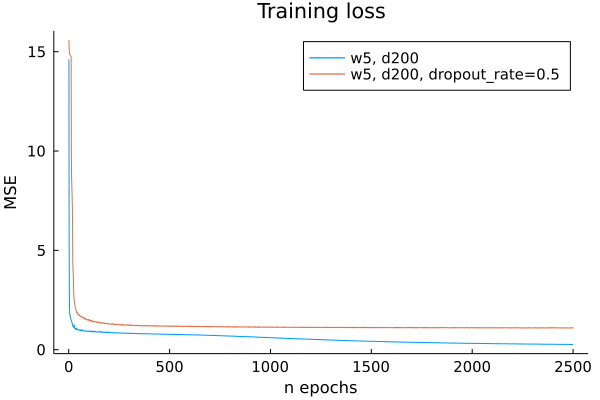

In [45]:
# plot training history
plot(epochs, training_losses;
    title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false,
    label="w5, d200", dpi=400, grid=false, xtickfontsize=10, ytickfontsize=10, legendfontsize=10)
plot!(epochs, training_losses_dropout;
    legend=true, label="w5, d200, dropout_rate=$dropout_rate")

#savefig("corr_decorr_training.png")

In [55]:
Flux.testmode!(m_dropout, true)

Chain(
  Dense(14 => 200, #101),               # 3_000 parameters
  Dropout(0.5),
  Dense(200 => 200, #102),              # 40_200 parameters
  Dropout(0.5),
  Dense(200 => 200, #103),              # 40_200 parameters
  Dropout(0.5),
  Dense(200 => 200, #104),              # 40_200 parameters
  Dropout(0.5),
  Dense(200 => 200, #105),              # 40_200 parameters
  Dropout(0.5),
  Dense(200 => 200, #106),              # 40_200 parameters
  Dropout(0.5),
  Dense(200 => 6),                      # 1_206 parameters
)                   # Total: 14 arrays, 205_206 parameters, 802.649 KiB.

## Model evaluation

In [56]:
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

y_train_preds_dropout = m_dropout(x_train')'
y_test_preds_dropout = m_dropout(x_test')'

43459×6 adjoint(::Matrix{Float64}) with eltype Float64:
  0.456126     -0.461356   -0.731993  -0.911534  -0.514971   -0.527343
  0.537474      0.184393   -0.706366  -0.896148  -0.445219   -0.460423
 -0.00201858   -0.300462   -0.289138  -0.899053  -0.188195   -0.221152
  0.310015      0.0670061  -0.28625   -0.949235  -0.617331   -0.622359
  0.724027      0.355808   -0.588297  -0.90232   -0.37825    -0.405928
  0.300002     -0.734662   -0.582652  -0.864196   0.0367615  -0.00574124
  0.620373     -0.415607   -0.755309  -0.884466  -0.30454    -0.315941
  0.712298      0.402092   -0.42315   -0.922244  -0.51123    -0.533915
 -0.571232     -0.46289    -0.4276    -0.957272  -0.814625   -0.803315
 -0.137539     -0.12252    -0.854082  -0.917188  -0.569078   -0.57256
  0.500745      0.376603   -0.532176  -0.928232  -0.54793    -0.564983
 -0.484151     -0.660004   -0.189912  -0.958224  -0.790263   -0.772605
  0.573941     -0.514919   -0.586113  -0.922556  -0.528064   -0.542041
  ⋮                 

In [57]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [58]:
println("without dropout:")
r2_train = r2score_multidim(y_train, y_train_preds)
r2_test = r2score_multidim(y_test, y_test_preds)
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

println("with dropout")
r2_train_dropout = r2score_multidim(y_train, y_train_preds_dropout)
r2_test_dropout = r2score_multidim(y_test, y_test_preds_dropout)
println("r2 on training set: $r2_train_dropout")
println("r2 on test set: $r2_test_dropout")

without dropout:
r2 on training set: 0.9689176442524478
r2 on test set: 0.8593519404270333
with dropout
r2 on training set: 0.8597560184660352
r2 on test set: 0.8608930888426357


In [59]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [60]:
println("without dropout")
adjustedr2_train = adjustedr2score_multidim(y_train, y_train_preds, size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, y_test_preds, size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

println("with dropout")
adjustedr2_train_dropout = adjustedr2score_multidim(y_train, y_train_preds_dropout, size(x_train, 2))
adjustedr2_test_dropout = adjustedr2score_multidim(y_test, y_test_preds_dropout, size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train_dropout")
println("adjustedr2 on test set: $adjustedr2_test_dropout")

without dropout
adjustedr2 on training set: 0.9689151407690514
adjustedr2 on test set: 0.859306616036231
with dropout
adjustedr2 on training set: 0.8597447227173457
adjustedr2 on test set: 0.8608482610929764


In [61]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

println("MAPEs on test sets")
for i in 1:y_dimension
    temp_train_trues_normalized = y_train[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_test_preds_normalized = y_test_preds[:, i]
    
    temp_train_preds_normalized_dropout = y_train_preds_dropout[:, i]
    temp_test_preds_normalized_dropout = y_test_preds_dropout[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    fit!(y_scaler, y_df[!, "OBJ$i"])
    
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_train_preds_original_dropout = inverse_transform(y_scaler, temp_train_preds_normalized_dropout)
    temp_test_preds_original_dropout = inverse_transform(y_scaler, temp_test_preds_normalized_dropout)
    
    println(
        "OBJ$i WITHOUT dropout: ",
        mape(temp_test_preds_original, temp_test_trues_original)
    )
    println(
        "OBJ$i WITH dropout: ",
        mape(temp_test_preds_original_dropout, temp_test_trues_original)
    )
end

MAPEs on test sets
OBJ1 WITHOUT dropout: 0.021256531800910916
OBJ1 WITH dropout: 0.045849926161507626
OBJ2 WITHOUT dropout: 0.022755097233636494
OBJ2 WITH dropout: 0.01912033879350443
OBJ3 WITHOUT dropout: 0.021381040708805234
OBJ3 WITH dropout: 0.038796262003115256
OBJ4 WITHOUT dropout: 0.09246590909428946
OBJ4 WITH dropout: 0.18550147597468342
OBJ5 WITHOUT dropout: 0.14575053298029372
OBJ5 WITH dropout: 0.1282999301424896
OBJ6 WITHOUT dropout: 0.14560998110458395
OBJ6 WITH dropout: 0.12944899010454755


In [63]:
i = 7
println("true: ", y_test[i, :])
println("predicted w/o dropout: ", y_test_preds[i, :])
println("predicted with dropout: ", y_test_preds_dropout[i, :])

true: [0.6541798012359037, -0.5365854212565542, -0.807582832554778, -0.8686708475672449, -0.3921588619971964, -0.197258891916556]
predicted w/o dropout: [0.6366578027656156, -0.34943399911367895, -0.7964936825369417, -0.8642841504888492, -0.241835890939951, -0.38350051025212584]
predicted with dropout: [0.6203734389084958, -0.4156068807964545, -0.7553088795323879, -0.8844656608896319, -0.3045398348182944, -0.3159410075274834]
